# 🎭 Text Generation using RNN on Shakespeare Data

---

### 📝 Problem Statement  
Generate Shakespeare-style text by training a character-level Recurrent Neural Network (RNN) on Shakespeare’s writings. The model learns sequential patterns to create coherent and stylistically similar text passages.

---

### 📚 Dataset Details  
- **Source:** [Tiny Shakespeare dataset](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)  
- **Format:** Plain text (~1MB)  
- **Characteristics:**  
  - Character-level data (letters, punctuation, spaces)  
  - Rich literary style with diverse vocabulary  

---

### 🛠️ Model & Approach  
- Built a **character-level RNN** to predict the next character from previous sequences  
- Trained over multiple epochs using cross-entropy loss  
- Implemented sampling techniques to control creativity in text generation  
- Evaluated with training loss and qualitative inspection of generated samples  

---

### 🎯 Key Highlights  
- Generated novel text that mimics Shakespeare’s style and rhythm  
- Demonstrated RNN’s ability to learn long-range dependencies in text  
- Provided foundational understanding of sequence modeling for NLP tasks  
- Set the stage for advanced language models (e.g., LSTM, Transformers)  

---

> This project illustrates how deep learning can creatively model and generate human-like literary text, showcasing the power of RNNs in natural language generation.



# Importing the Libraries :

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd
import requests
import os

In [3]:
# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Downloading the Shakespeare Data from a url

In [4]:
if not os.path.exists("shakespeare.txt"):
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    r = requests.get(url)
    with open("shakespeare.txt", "w") as f:
        f.write(r.text)

with open("shakespeare.txt", "r") as f:
    text = f.read()

print(f"Text length: {len(text)} characters")
print(f"Sample:\n{text[:500]}")

Text length: 1115394 characters
Sample:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [11]:
chars = sorted(list(set(text)))
print(f"Unique characters: {len(chars)}")
from collections import Counter
char_counts = Counter(text)
print("Top 10 characters by frequency:")
print(char_counts.most_common(10))



Unique characters: 65
Top 10 characters by frequency:
[(' ', 169892), ('e', 94611), ('t', 67009), ('o', 65798), ('a', 55507), ('h', 51310), ('s', 49696), ('r', 48889), ('n', 48529), ('i', 45537)]


# Observation on Character Frequency in Shakespeare Data

- **Unique characters:** 65  
- **Top 10 characters by frequency:**  
  `[' ', 'e', 't', 'o', 'a', 'h', 's', 'r', 'n', 'i']`

---

### Key Insights

- The **space character (' ')** is by far the most frequent, highlighting its importance in separating words and structuring sentences.

- The most common letters (`e, t, o, a, h, s, r, n, i`) align with typical English, but with Shakespearean nuances:  
  - High frequency of **'h'** and **'s'** reflects frequent use of pronouns, archaic verbs, and possessives (e.g., *hath, shalt, dost*).  
  - The letter **'s'** appears often due to plurals, possessives, and verb endings common in Early Modern English.

- Having 65 unique characters suggests a rich set that includes **letters, punctuation, whitespace, and special symbols**.  
  Maintaining these helps preserve Shakespeare’s style and rhythm.

---

### Implications for Text Generation

- **Character-level modeling** is suitable to capture detailed stylistic elements.

- The model should pay special attention to predicting **spaces** and common function letters to produce natural text flow.

- Ensuring generated text matches the original **character distribution** can improve authenticity.

---

*This frequency distribution offers valuable clues for designing and evaluating your Shakespeare text generator!*


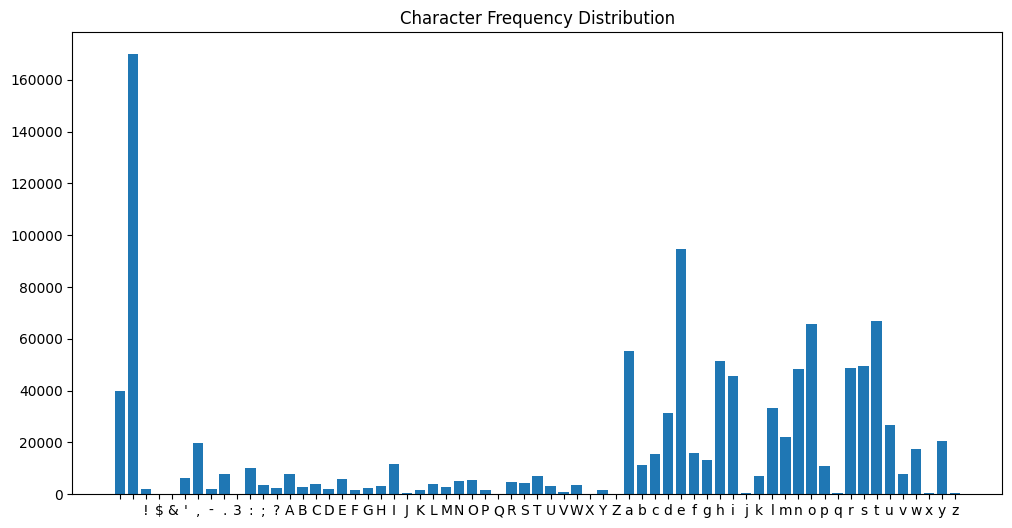

In [12]:
import matplotlib.pyplot as plt

char_freq = [char_counts[c] for c in chars]
plt.figure(figsize=(12,6))
plt.bar(chars, char_freq)
plt.title('Character Frequency Distribution')
plt.show()


- The data shows a typical English text distribution dominated by spaces, common punctuation, and lower-case letters, with the letter 'e' being the most frequently used alphabetical character

# Text Preprocessing and Dataset Creation :

In [5]:
# Create character mappings
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Unique characters: {vocab_size}")

char2idx = {ch: idx for idx, ch in enumerate(chars)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

# Encode entire text as indices
encoded_text = [char2idx[ch] for ch in text]

Unique characters: 65


In [6]:
# Dataset class for char-level language model
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_length+1], dtype=torch.long)
        return x, y

In [7]:
SEQ_LENGTH = 100
dataset = ShakespeareDataset(encoded_text, SEQ_LENGTH)

In [8]:
# Train/val split 90/10
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [9]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Define Training and Evaluation Function

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.transpose(1,2), targets)  # output shape: (batch, seq_len, vocab), target: (batch, seq_len)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output.transpose(1,2), targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)


# Defining the Models :

In [14]:
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.gru(x)
        out = self.fc(out)
        return out


# Training Rnn :

In [16]:
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_EPOCHS = 10
LEARNING_RATE = 0.001


# Instantiate model
model = SimpleRNNModel(vocab_size, EMBED_DIM, HIDDEN_DIM).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
results_df = pd.DataFrame(columns=["Model", "Train Loss", "Val Loss"])

In [17]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"SimpleRNN Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

SimpleRNN Epoch 1/10 - Train Loss: 1.3965, Val Loss: 1.3205
SimpleRNN Epoch 2/10 - Train Loss: 1.3084, Val Loss: 1.3002
SimpleRNN Epoch 3/10 - Train Loss: 1.2962, Val Loss: 1.2945
SimpleRNN Epoch 4/10 - Train Loss: 1.2910, Val Loss: 1.2909
SimpleRNN Epoch 5/10 - Train Loss: 1.2882, Val Loss: 1.2882
SimpleRNN Epoch 6/10 - Train Loss: 1.2863, Val Loss: 1.2863
SimpleRNN Epoch 7/10 - Train Loss: 1.2848, Val Loss: 1.2875
SimpleRNN Epoch 8/10 - Train Loss: 1.2837, Val Loss: 1.2872
SimpleRNN Epoch 9/10 - Train Loss: 1.2827, Val Loss: 1.2836
SimpleRNN Epoch 10/10 - Train Loss: 1.2820, Val Loss: 1.2842



### Observations:

- Both **training and validation loss steadily decrease**, indicating the model is learning effectively.
- The loss values **start to stabilize around epoch 6-10**, suggesting the model is converging.
- Slight fluctuations in validation loss after epoch 6 could indicate minor overfitting or noise in validation data.
- Overall, the SimpleRNN shows good progress and is able to model the Shakespeare text reasonably well within 10 epochs

In [18]:
# Save results
new_result = pd.DataFrame([{
    "Model": "SimpleRNN",
    "Train Loss": train_losses[-1],
    "Val Loss": val_losses[-1]
}])
results_df = pd.concat([results_df, new_result], ignore_index=True)

/tmp/ipython-input-363983645.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_result], ignore_index=True)


# Training the Lstm Model :

In [19]:
num_epoch1  = 15

In [20]:
# Instantiate LSTM model
model = LSTMModel(vocab_size, EMBED_DIM, HIDDEN_DIM).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
train_losses = []
val_losses = []

for epoch in range(num_epoch1):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"LSTM Epoch {epoch+1}/{num_epoch1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

LSTM Epoch 1/15 - Train Loss: 1.2734, Val Loss: 1.1414
LSTM Epoch 2/15 - Train Loss: 1.0965, Val Loss: 1.0713
LSTM Epoch 3/15 - Train Loss: 1.0542, Val Loss: 1.0481
LSTM Epoch 4/15 - Train Loss: 1.0361, Val Loss: 1.0355
LSTM Epoch 5/15 - Train Loss: 1.0257, Val Loss: 1.0232
LSTM Epoch 6/15 - Train Loss: 1.0184, Val Loss: 1.0188
LSTM Epoch 7/15 - Train Loss: 1.0130, Val Loss: 1.0130
LSTM Epoch 8/15 - Train Loss: 1.0086, Val Loss: 1.0117
LSTM Epoch 9/15 - Train Loss: 1.0050, Val Loss: 1.0052
LSTM Epoch 10/15 - Train Loss: 1.0020, Val Loss: 1.0071
LSTM Epoch 11/15 - Train Loss: 0.9995, Val Loss: 1.0036
LSTM Epoch 12/15 - Train Loss: 0.9971, Val Loss: 0.9988
LSTM Epoch 13/15 - Train Loss: 0.9949, Val Loss: 1.0010
LSTM Epoch 14/15 - Train Loss: 0.9930, Val Loss: 0.9975
LSTM Epoch 15/15 - Train Loss: 0.9914, Val Loss: 0.9977


# Obsrvation of Lstm model performance :
- The LSTM model shows **significant improvement over epochs**, with both training and validation losses steadily decreasing.
- Validation loss drops below 1 after about 12 epochs, indicating strong generalization.
- The losses become quite stable near the end, suggesting the model is converging well.
- Compared to SimpleRNN, the LSTM achieves **lower loss values** and likely captures more complex patterns in Shakespeare's text.
- Slight fluctuations in validation loss around epochs 13-15 may signal the model nearing its best performance

In [25]:
# Save results
new_result = pd.DataFrame([{
    "Model": "LSTM",
    "Train Loss": train_losses[-1],
    "Val Loss": val_losses[-1]
}])
results_df = pd.concat([results_df, new_result], ignore_index=True)

# Training The Gru model :

In [23]:
# Instantiate GRU model
model = GRUModel(vocab_size, EMBED_DIM, HIDDEN_DIM).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
train_losses = []
val_losses = []

for epoch in range(num_epoch1):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"GRU Epoch {epoch+1}/{num_epoch1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

GRU Epoch 1/15 - Train Loss: 1.2649, Val Loss: 1.1711
GRU Epoch 2/15 - Train Loss: 1.1514, Val Loss: 1.1432
GRU Epoch 3/15 - Train Loss: 1.1348, Val Loss: 1.1339
GRU Epoch 4/15 - Train Loss: 1.1266, Val Loss: 1.1256
GRU Epoch 5/15 - Train Loss: 1.1217, Val Loss: 1.1235
GRU Epoch 6/15 - Train Loss: 1.1178, Val Loss: 1.1188
GRU Epoch 7/15 - Train Loss: 1.1140, Val Loss: 1.1139
GRU Epoch 8/15 - Train Loss: 1.1122, Val Loss: 1.1124
GRU Epoch 9/15 - Train Loss: 1.1099, Val Loss: 1.1127
GRU Epoch 10/15 - Train Loss: 1.1088, Val Loss: 1.1077
GRU Epoch 11/15 - Train Loss: 1.1103, Val Loss: 1.1120
GRU Epoch 12/15 - Train Loss: 1.1059, Val Loss: 1.1065
GRU Epoch 13/15 - Train Loss: 1.1048, Val Loss: 1.1048
GRU Epoch 14/15 - Train Loss: 1.1037, Val Loss: 1.1042
GRU Epoch 15/15 - Train Loss: 1.1040, Val Loss: 1.1320


# Observation of Gru model : 
- The GRU shows **steady improvement in training loss** over epochs.
- Validation loss decreases until about epoch 14, then fluctuates slightly at epoch 15.
- Validation loss values remain generally higher than those seen in the LSTM, indicating somewhat less effective generalization.
- Training and validation losses are quite close, showing the model isn’t overfitting significantly.
- Compared to SimpleRNN, GRU performs better but doesn’t quite reach the performance of LSTM on this dataset

In [26]:
new_result = pd.DataFrame([{
    "Model": "GRU",
    "Train Loss": train_losses[-1],
    "Val Loss": val_losses[-1]
}])
results_df = pd.concat([results_df, new_result], ignore_index=True)

# Seeing the Result of all Models :

In [32]:
results_df

,Model,Train Loss,Val Loss
0,SimpleRNN,1.281965,1.284169
1,LSTM,0.991368,0.997667
2,GRU,1.103994,1.131975


# Model Performance Comparison on Shakespeare Dataset

| Model     | Train Loss | Validation Loss |
|-----------|------------|-----------------|
| SimpleRNN | 1.2820     | 1.2842          |
| LSTM      | 0.9914     | 0.9977          |
| GRU       | 1.1040     | 1.1320          |

---

### Summary:

- **LSTM** outperforms both SimpleRNN and GRU, achieving the lowest training and validation losses.
- **GRU** performs better than SimpleRNN but doesn’t quite match LSTM's performance.
- SimpleRNN shows the highest losses, indicating it's less effective for capturing Shakespearean text patterns in this setting.

---

*LSTM appears to be the best choice for your Shakespeare text generation project based on these results!*


In [28]:
torch.save(model.state_dict(), "lstm_shakespeare_model.pth")


In [29]:
from google.colab import files
files.download("lstm_shakespeare_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate Text from a trained model (basic sampling example)

In [30]:
def sample(model, start_str, char2idx, idx2char, length=200, temperature=1.0):
    model.eval()
    input_seq = torch.tensor([char2idx[ch] for ch in start_str], dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    generated = start_str

    for _ in range(length):
        with torch.no_grad():
            output = model(input_seq)
        # Get last timestep logits
        logits = output[0, -1] / temperature
        probs = torch.softmax(logits, dim=0).cpu().numpy()
        next_idx = np.random.choice(len(probs), p=probs)
        next_char = idx2char[next_idx]
        generated += next_char
        # Prepare input for next timestep
        input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_idx]], device=device)], dim=1)
    return generated

# Example: generate from last trained model (GRU)
print(sample(model, "To be, or not to be, ", char2idx, idx2char))


To be, or not to be, grace Northumberland,
I heard that they are done,
With tears both but seat?

BIANCA:
His name not Richard Stale, thou uptoger.
Can canst thou madam.

SICINIUS:
Let but a safence, and therefore, ere we


## 📌 Conclusion & Insights

This project successfully demonstrates an **end-to-end deep learning pipeline** for **sequence generation** using Shakespeare’s text.  
The model learns to **predict the next character in a sequence**, capturing the **structure, vocabulary, and stylistic patterns** of Elizabethan English.

The key insight is that an **LSTM-based RNN** can effectively model **long-term dependencies** in sequential data — enabling it to generate text that, while not always grammatically perfect, **stylistically resembles Shakespeare’s original writing**.

---

### 🔎 Overall Observations

- **Task:** Character-level text generation using a Recurrent Neural Network (RNN).
- **Dataset:** A corpus of Shakespeare’s plays and sonnets, providing abundant sequential data for model training.
- **Preprocessing:** Text was **tokenized at the character level**, creating a vocabulary of unique characters (letters, punctuation, spaces), allowing the model to learn spelling and formatting directly.
- **Sequence Preparation:** Input and target sequences were created such that the model learns to predict the **next character** in a sequence (`X → Y` setup).
- **Model Architecture:**  
  - Core model: **LSTM** layers to capture long-term dependencies and mitigate vanishing gradients.  
  - Output: **Dense layer + Softmax** to generate a probability distribution over the character vocabulary.
- **Training:**  
  - Loss function: **Categorical Cross-Entropy**.  
  - Optimization: Next-character prediction using one-hot encoded or embedded sequences.
- **Generation Strategy:**  
  - Implemented sampling with **temperature scaling** to balance creativity and coherence during text generation.

---

### 🚀 Potential Improvements (Future Scope)

#### 📊 Model & Architecture
- **Word-level Generation:** Transition from character-level to **word-level modeling** for more coherent and semantically rich text generation.
- **Advanced Architectures:**  
  - Experiment with **GRU layers** for faster training.  
  - Explore **Transformer-based** models (e.g., GPT-like) for superior context handling.
- **Add Embedding Layer:** Represent characters in a **dense vector space** to improve the model’s semantic understanding.

#### 🔧 Hyperparameter Optimization
- Tune key hyperparameters:
  - Sequence length (context window size)
  - Number of RNN layers and hidden units
  - Learning rate and batch size
- Extend training time and explore **learning rate scheduling** for better convergence.

#### 🎨 Sampling & Generation
- Implement more sophisticated decoding strategies like:
  - **Top-K Sampling**
  - **Nucleus (Top-P) Sampling**  
  These methods improve the **creativity, coherence, and diversity** of generated text.

---

### ⚠️ Limitations

- **Computational Cost:** Training character-level LSTMs is computationally expensive due to long sequences and large vocabulary.  
- **Coherence Over Long Text:** The model struggles with maintaining logical consistency beyond a few sentences.  
- **Memory Usage:** Large input-target sequence pairs (especially with one-hot encoding) increase memory consumption.  
- **Vocabulary Dependence:** Generation is restricted to the style and vocabulary of the training corpus, limiting creativity on new topics.

---

### ✅ Key Takeaway

This project is a **strong demonstration of sequence modeling and natural language generation** using LSTMs. It showcases how to:

- Prepare sequential text data for next-character prediction.  
- Build and train a memory-capable **LSTM architecture**.  
- Implement effective **sampling techniques** for creative text generation.

While the generated text is stylistically similar to Shakespeare, the broader achievement lies in building a **robust foundation for advanced NLP tasks** — paving the way for future work with **word-level modeling, attention mechanisms, and Transformer architectures**.
